In [1]:
import os, glob, pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image

import IPython

c:\Users\fcoel\miniconda3\envs\apc-project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
from sklearn.metrics import f1_score, balanced_accuracy_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


# Notebook description

## Goal

For the 3 top-scoring models, we fine-tune them harder and build an ensemble with the results.

## Methods

For metrics, we will consider the 

- F1-score (per-class and micro-average)
- Accuracy (per-class)
- Balanced Accuracy


In [3]:
with open("../models/embedding_train.pickle", "rb") as handle:
    train_feats = pickle.load(handle)

with open("../models/embedding_validation.pickle", "rb") as handle:
    validation_feats = pickle.load(handle)

with open("../models/labels.pickle", "rb") as handle:
    labels_dict = pickle.load(handle)

In [4]:
train_labels = labels_dict["train"]
validation_labels = labels_dict["validation"]
categories = labels_dict["categorical"]

### Instantiate models and define search space


$$[0, 1] \to [x, x+\delta]$$

$$
[x, \omega x] \Rightarrow x + \delta = \omega x \Rightarrow (\omega - 1) x = \delta \Rightarrow \omega = 1 + \frac{\delta}{x}
$$

In [11]:
##########
sgd_log = SGDClassifier()

sgd_log_params = {
    "loss": ["log_loss"],
    "alpha": uniform(loc=0.01, scale=(100-1)*0.01)
}
##########
sgd_huber = SGDClassifier()

sgd_huber_params = {
    "loss": ["modified_huber"],
    "alpha": uniform(loc=0.01, scale=(100-1)*0.01)
}
##########
kNN = KNeighborsClassifier()

kNN_params = {
    "n_neighbors": [5, 10, 15, 20, 30, 40],
    "weights": ["uniform", "distance"],
    "leaf_size": [15, 30, 45]
}
##########

# models = [sgd_log, sgd_huber]

# model_params = [sgd_log_params, sgd_huber_params]


models = [kNN]

model_params = [kNN_params]

In [12]:
best_models = []
best_params = []
best_scores = []
best_valid_scores = []

for model, param in zip(models, model_params):

    # cv = RandomizedSearchCV(model, param, n_iter=50, cv=5, scoring="balanced_accuracy", verbose=3)
    cv = GridSearchCV(model, param, cv=5, scoring="balanced_accuracy", verbose=3)

    search = cv.fit(train_feats, train_labels)

    best_models.append(search.best_estimator_)
    best_params.append(search.best_params_)
    best_scores.append(search.best_score_)  

    preds = search.best_estimator_.predict(validation_feats)
    valid_score = balanced_accuracy_score(validation_labels, preds)
    
    best_valid_scores.append(valid_score) 



Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END leaf_size=15, n_neighbors=5, weights=uniform;, score=0.847 total time=   3.1s
[CV 2/5] END leaf_size=15, n_neighbors=5, weights=uniform;, score=0.864 total time=   2.4s
[CV 3/5] END leaf_size=15, n_neighbors=5, weights=uniform;, score=0.855 total time=   2.4s
[CV 4/5] END leaf_size=15, n_neighbors=5, weights=uniform;, score=0.840 total time=   2.5s
[CV 5/5] END leaf_size=15, n_neighbors=5, weights=uniform;, score=0.856 total time=   2.6s
[CV 1/5] END leaf_size=15, n_neighbors=5, weights=distance;, score=0.850 total time=   2.3s
[CV 2/5] END leaf_size=15, n_neighbors=5, weights=distance;, score=0.868 total time=   2.6s
[CV 3/5] END leaf_size=15, n_neighbors=5, weights=distance;, score=0.858 total time=   2.5s
[CV 4/5] END leaf_size=15, n_neighbors=5, weights=distance;, score=0.844 total time=   2.6s
[CV 5/5] END leaf_size=15, n_neighbors=5, weights=distance;, score=0.856 total time=   2.6s
[CV 1/5] END leaf_size=

In [13]:
best_scores, best_valid_scores

([0.8607505210159321], [0.8596988792817664])

In [14]:
best_models

[KNeighborsClassifier(leaf_size=15, n_neighbors=10, weights='distance')]

In [27]:
from sklearn.ensemble import VotingClassifier

models = [
    SGDClassifier(alpha=0.019323822134521308, loss='log_loss'),
    SGDClassifier(alpha=0.26007184302607766, loss='modified_huber'),
    KNeighborsClassifier(leaf_size=15, n_neighbors=10, weights='distance')
]

names = ["logistic_reg", "huber_loss", "knn"]

ensemble_model = VotingClassifier(estimators=list(zip(names, models)),
                                  voting="soft", weights=[2, 2, 1])

In [28]:
ensemble_model.fit(train_feats, train_labels)

VotingClassifier(estimators=[('logistic_reg',
                              SGDClassifier(alpha=0.019323822134521308,
                                            loss='log_loss')),
                             ('huber_loss',
                              SGDClassifier(alpha=0.26007184302607766,
                                            loss='modified_huber')),
                             ('knn',
                              KNeighborsClassifier(leaf_size=15, n_neighbors=10,
                                                   weights='distance'))],
                 voting='soft', weights=[2, 2, 1])

In [29]:
ensemble_preds = ensemble_model.predict(validation_feats)

In [30]:
balanced_accuracy_score(validation_labels, ensemble_preds)

0.906201956287838

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

In [32]:
my_results = {}


for i, model in enumerate(models + [ensemble_model]):
    print(f"Evaluating model {model}")
    # Convert multiclass to One vs All
    label_binarizer = LabelBinarizer().fit(train_labels)

    # Convert train/validation labels
    y_onehot_train = label_binarizer.transform(train_labels)
    y_onehot_test = label_binarizer.transform(validation_labels)

    # print(validation_labels.shape, y_onehot_test.shape)

    print(f"Computing ROCs")
    # Compute ROC curve for each class
    fprs, tprs, trs = [], [], []
    for class_of_interest in range(6):

        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        # Fit model explicity with One-vs-All strategy
        model.fit(train_feats, y_onehot_train[:, class_id])
        # Make predictions
        preds = model.predict(validation_feats)
        scores = model.predict_proba(validation_feats)

        # print(preds.shape, scores.shape, y_onehot_test.shape)

        # Compute metrics
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, class_id], scores[:, 1])

        # Store results
        fprs.append(fpr)
        tprs.append(tpr)
        trs.append(thresholds)


    # Fit model using internal multiclass handling
    model.fit(train_feats, train_labels)
    # Make predictions
    preds = model.predict(validation_feats)
    scores = model.predict_proba(validation_feats)

    # print(preds.shape, scores.shape)

    print(f"Computing other metrics")

    microf1 = f1_score(validation_labels, preds, average="micro")
    bal_acc = balanced_accuracy_score(validation_labels, preds)
    auc = roc_auc_score(
                    validation_labels,
                    scores,
                    multi_class="ovr",
                    average="macro"
    )


    print(f"Model: {model}, index: {i}")

    my_results[i] = {"microf1": microf1, "bal_acc": bal_acc, "macro_avg_auc": auc, "fpr": fprs, "tpr": tprs, "thresholds": trs}



Evaluating model SGDClassifier(alpha=0.019323822134521308, loss='log_loss')
Computing ROCs
Computing other metrics
Model: SGDClassifier(alpha=0.019323822134521308, loss='log_loss'), index: 0
Evaluating model SGDClassifier(alpha=0.26007184302607766, loss='modified_huber')
Computing ROCs
Computing other metrics
Model: SGDClassifier(alpha=0.26007184302607766, loss='modified_huber'), index: 1
Evaluating model KNeighborsClassifier(leaf_size=15, n_neighbors=10, weights='distance')
Computing ROCs
Computing other metrics
Model: KNeighborsClassifier(leaf_size=15, n_neighbors=10, weights='distance'), index: 2
Evaluating model VotingClassifier(estimators=[('logistic_reg',
                              SGDClassifier(alpha=0.019323822134521308,
                                            loss='log_loss')),
                             ('huber_loss',
                              SGDClassifier(alpha=0.26007184302607766,
                                            loss='modified_huber')),
           

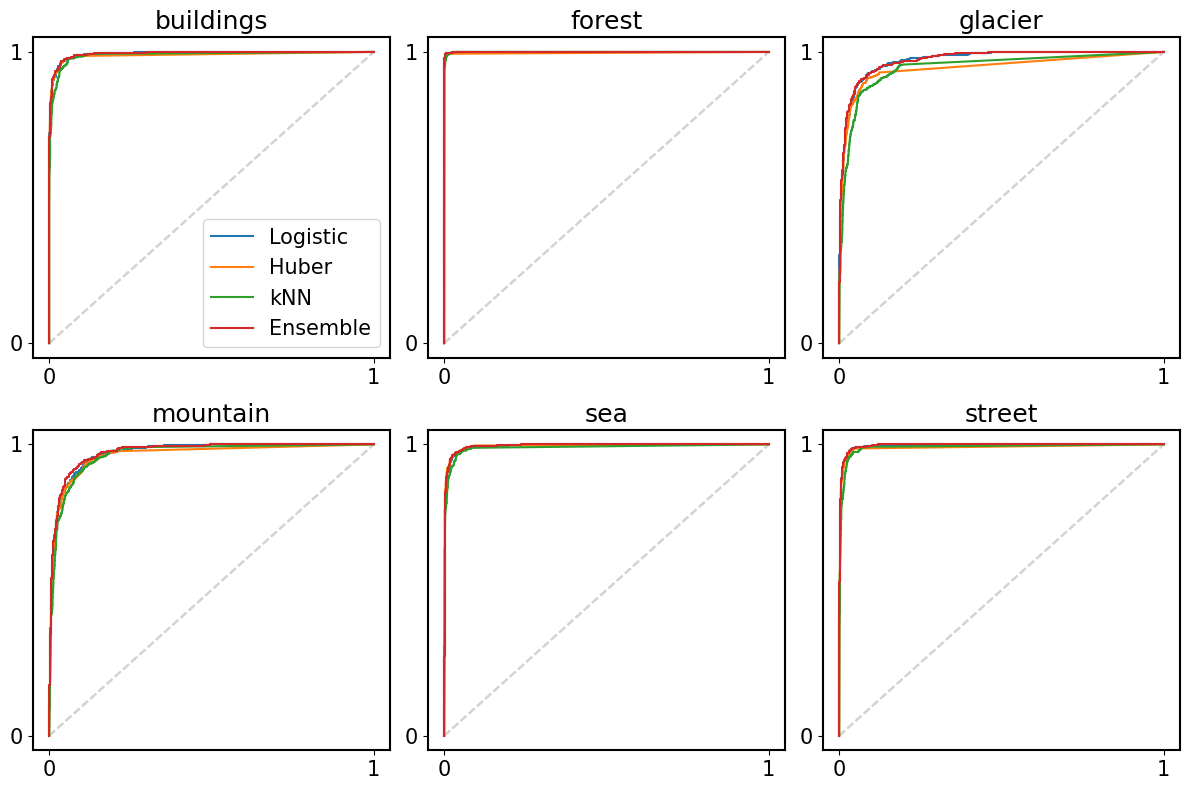

In [76]:
# Plot ROCs
# my_results[i] = {"microf1": microf1, "bal_acc": bal_acc, "macro_avg_auc": auc, "fpr": fprs, "tpr": tprs, "thresholds": trs}


names = ["Logistic", "Huber", "kNN", "Ensemble"]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i in range(4):

    val = my_results[i]

    fpr, tpr = val["fpr"], val["tpr"]

    count = 0
    for j in range(2):
        for k in range(3):
            ca = ax[j, k]
            
            ca.plot(fpr[count], tpr[count], label=names[i])
            ca.plot([0, 1], [0, 1], ls="--", c="lightgrey", zorder=-5, alpha=0.6)

            if count == 0:
                ca.legend(fontsize=15)
            ca.set_title(categories[count], fontsize=18)
            ca.set_xticks([0, 1])
            ca.set_yticks([0, 1])
            ca.tick_params(labelsize=15)

            count += 1

    fig.tight_layout()

    # fig.savefig("../images/roc_per_class_finetuned.png", dpi=400)

In [77]:
# my_results[i] = {"microf1": microf1, "bal_acc": bal_acc, "macro_avg_auc": auc, "fpr": fprs, "tpr": tprs, "thresholds": trs}

names = ["Logistic", "Huber", "kNN", "Ensemble"]

scores_full = []

for i in range(4):

    val = my_results[i]

    scores = [val["microf1"], val["bal_acc"], val["macro_avg_auc"]]

    scores_full.append(scores)

In [81]:
scores_df = pd.DataFrame(data=scores_full, index=names, columns=["Micro-averaged F1", "Balanced Accuracy", "Macro-averaged AUC"])

TypeError: DataFrame.__init__() got an unexpected keyword argument 'indexes'

In [79]:
scores_df

,0,1,2
0,0.907333,0.910449,0.989341
1,0.902000,0.905936,0.977801
2,0.854000,0.859699,0.979642
3,0.904000,0.907975,0.989484
